# <center>Music Prediction</center>


In this file, we use a neural network to predict the genre of music from 8 bars.

We copied a lot from Homework 4 because we have already done the work of creating neural networks.

# Essential imports and ground constants
Run everything in the following cells to get basic data and imports.

In [1]:
import os
import json
import mido
from mido import MidiFile
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import plotly
import plotly.graph_objects as go
import random, time
from collections import Counter
from sklearn.model_selection import train_test_split
import json
import math
from sklearn.datasets import fetch_openml

In [2]:
##make sure to set WORKING_DIRECTORY to where the 'Data' folder is at
WORKING_DIRECTORY = r"C:\Users\timot\Documents\GitHub\MAT_180_ML_Projects\midi-synthesis\Data"

##this specifies how deep to search every folder in 'Data'.
FILE_DEPTH = 3

##this specifies how many notes we want to compute later, quantized to sixteenth notes
##so 8 bars in common time is equal to a capacity of 128
CAPACITY = 256

##if our dataset grows, change this to reflect new genres added
##alternatively, we can use the number of keys in genres_dict instead.
UNIQUE_GENRES = 18

# Forming genres_dict
From the folder 'Data', we create a dictionary `genres_dict` which contains keys as genres and elements of that key as lists of music associated with that genre. If you want to load the entire set which contains corrupted data as well, run the following cell. If not, skip to <b>Load Uncorrupted Genres_Dict</b>

In [4]:
# collects midi files from a given folder
def collect_midi_files(midi_files):
    for element in os.listdir():
        if os.path.isdir(os.getcwd() + "/" + element):
            # print(f'folder: {element}')
            os.chdir(os.getcwd() + "/" + element)
            midi_files = collect_midi_files(midi_files)
            os.chdir("..")
        elif element.endswith(".mid"): # change to .mid
            # print(f'file: {element}')
            midi_files.append(element)
    return midi_files

os.chdir(WORKING_DIRECTORY)

genres_dict = {}

for element in os.listdir():
    if os.path.isdir(os.getcwd() + "/" + element):
        os.chdir(os.getcwd() + "/" + element)
        midi_names = []
        midi_names = collect_midi_files(midi_names)
        if midi_names != []:
            genres_dict[element] = midi_names
        os.chdir("..")

print(f'{len(genres_dict)} genres found')
print(f'Genres: {genres_dict.keys()}')

count = 0
for keys in genres_dict.keys():
    for list in genres_dict[keys]:
        count += 1
        
print("\ngenres_dict has",count,"elements")

18 genres found
Genres: dict_keys(['Ambient', 'Blues', 'Children', 'Classical', 'Country', 'Electronic', 'Folk', 'Jazz', 'Latin', 'Pop', 'Rap', 'Reggae', 'Religious', 'Rock', 'Soul', 'Soundtracks', 'Unknown', 'World'])

genres_dict has 11075 elements


Like many massive datasets uncautiously curated, there are corrupted data. Below is an example

In [7]:
# #example corrupted Midi file
# mid = getMidiFile('Fig Leaf Rag.mid')

This method below removes all corrupted data from genres_dict. Running cleanData() will take approximately an hour.

In [13]:
def memoize(f):
    Cache = {}
    
    def f_memoized(*args):
        if (f, args) in Cache:
            return Cache[(f, args)]
        result = f(*args)
        Cache[(f, args)] = result
        return result
    
    return f_memoized

# # genres_dict = {'Ambient':['Fig Leaf Rag.mid','Edvard Grieg Ich liebe dich.mid']}
# @memoize
# def cleanData():
#     errorCount = 0
#     count = 0
#     for keys in genres_dict.keys():
#         for item in genres_dict[keys]:
#             if count%100 == 0 and count > 1:
#                 print("Went through",count,"files so far.")
#             try:
#                 getMidiFile(item)
#             except:
#                 genres_dict[keys].remove(item)
#                 errorCount += 1
#             count += 1

#     count = 0
#     for keys in genres_dict.keys():
#         for list in genres_dict[keys]:
#             count += 1
#     print("There were",errorCount,"corrupted files.")
#     print("Uncorrupted genres_dict has",count,"files.")

In [9]:
# ##takes approximately an hour
# cleanData()

# Load Uncorrupted genres_dict
This cell below returns `genres_dict` just like above, but without corrupted files and is much faster.

In [11]:
os.chdir(WORKING_DIRECTORY)
os.chdir("..")

with open('uncorrupted.txt') as f:
    data = f.read()

genres_dict = json.loads(data)

print(f'{len(genres_dict)} genres found')
print(f'Genres: {genres_dict.keys()}')

count = 0
for keys in genres_dict.keys():
    for list in genres_dict[keys]:
        count += 1

print("\nUncorrupted genres_dict has",count,"elements")

18 genres found
Genres: dict_keys(['Ambient', 'Blues', 'Children', 'Classical', 'Country', 'Electronic', 'Folk', 'Jazz', 'Latin', 'Pop', 'Rap', 'Reggae', 'Religious', 'Rock', 'Soul', 'Soundtracks', 'Unknown', 'World'])

Uncorrupted genres_dict has 11000 elements


# Important methods
Run everything below to get necessary methods for the neural network

In [14]:
def getNotes(mid,trackNo):
    notes = []
    for msg in mid.tracks[trackNo]:
        if msg.type == 'note_on':
            notes.append(msg)
    return notes  

def getNotesTrack(track):
    notes = []
    for msg in track:
        if msg.type == 'note_on':
            notes.append(msg)
    return notes

def quantize16(notes):
    for i in range(len(notes)):
        if notes[i].velocity == 0 and notes[i].time > 50 and notes[i].time <= 60:
            notes[i] = notes[i].copy(time = 113)
    return notes

def absolutize(notes):
    #this methods returns a dictionary with notes matching the exact time
    for i in range(1,len(notes)):
        notes[i] = notes[i].copy(time = notes[i].time + notes[i-1].time)
    return notes

def trim(notes,capacity, pad = True):
    trimmed = []
    count = 0
    while count < capacity and count < len(notes):
        trimmed.append(notes[count])
        count += 1
    if pad == True:
        emptyNote = mido.Message('note_on', velocity = 0)
        while len(trimmed) < capacity:
            trimmed.append(emptyNote)
    return trimmed

@memoize
def getMidiFile(name):
    os.chdir(WORKING_DIRECTORY)
    found = False
    depth = FILE_DEPTH
    ##should never return "File not found!" if you are using genres_dict
    return getMidiFileRecur(name,found,depth)

getMidiFile = memoize(getMidiFile)
    
def getMidiFileRecur(name,found,depth):
    if depth >= 1:
        for element in os.listdir():
            if os.path.isdir(os.getcwd() + "/" + element):
                os.chdir(os.getcwd() + "/" + element)
                midi_names = []
                midi_names = collect_midi_files(midi_names)
                if name in midi_names:
                    found = True
                    return getMidiFileRecur(name,found,depth-1)
                    break
                os.chdir("..")
    else:
        if found == True:
            return MidiFile(name, clip = True)
        else:
            return "File not found!"
    return "File not found!"

#takes a MidiFile and returns only the trimmed notes
def compress(midiFile, pad = True):
    list = []
    for tracks in midiFile.tracks:
        list.append(tracks)
    
    merged = mido.merge_tracks(list)
    merged = getNotesTrack(merged)
    merged = trim(merged, CAPACITY, pad)
    
    return merged

def decoder(array):
    list = []
    for keys in genres_dict.keys():
        list.append(keys)
    index = np.argmax(array)

    return list[index]


In [15]:
##create the dataset and associated labels
##first pick random genre, and then pick a random song from that genre
genre = random.sample(sorted(genres_dict),1)[0]
music = random.sample(genres_dict[genre],1)[0]

print(genre,",",music)

Country , Still Crazy After All These Years.mid


In [16]:
#this returns a dictionary 
def genADLData(size):
    list = []
    for key in genres_dict.keys():
        list.append(key)
    genres = []
     
    for i in range(size):
        r = random.randint(0,len(list)-1)
        genres.append(list[r])
    
    music = []
    for item in genres:
        music = music + random.sample(genres_dict[item],1)    
    return genres,music

#gets MidiFiles from a list with str music entires
def getMidiList(musicList):
    for i in range(len(musicList)):
        musicList[i] = getMidiFile(musicList[i])
    return musicList
        
#gets only notes from a list with str music entries
def getNotesFromList(musicList):
    for i in range(len(musicList)):
        try:
            musicList[i] = compress(getMidiFile(musicList[i]))
        except:
            print(musicList[i],"causes error")
    return musicList
        
# print(music)
# print(len(getNotesFromList(music)[1]))

In [31]:
# run this cell to import needed modules and define plotting functions (no input needed)
# function to plot costs
def plot_costs(costs):
    plt.plot(costs)
    plt.xlabel("iterations")
    plt.ylabel("cost")
    plt.show()
    
# function to plot costs
def plot_grads(grads):
    plt.plot(grads)
    plt.xlabel("iterations")
    plt.ylabel("gradient norm")
    plt.show()

# defining a function to plot data
def plot_data(X,Y,size_ = 2):
    m = len(X)
    plot_figure = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=[r[0] for r in Y], mode='markers',marker=dict(size=size_))])
    plotly.offline.iplot(plot_figure)

# defining a function to plot models fit
def plot_fit(X,Y,W,B,G,size_ = 2):
    trace = go.Scatter3d(x=X[:,0], y=X[:,1], z=[r[0] for r in Y], mode='markers',marker=dict(size=size_))
    xs,ys = X[:,0],X[:,1]
    xxx = np.outer(np.linspace(min(xs), max(xs), 30), np.ones(30))
    yyy = np.outer(np.linspace(min(ys), max(ys), 30), np.ones(30)).T
    zzz = np.zeros([30,30])
    D = len(G)-1
    for i in range(30):
        for j in range(30):
            zzz[i,j] = feedforward(W,B,G,np.array([xxx[i,j],yyy[i,j]]))[D][0]
    # Configure the layout.
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    data = [trace,go.Surface(x=xxx, y=yyy, z=zzz, showscale=False, opacity=0.5)]
    # Render the plot.
    plot_figure = go.Figure(data=data, layout=layout)
    plot_figure.update_layout(
        scene = dict(
            xaxis = dict(nticks=4, range=[min(X[:,0]),max(X[:,0])],),
            yaxis = dict(nticks=4, range=[min(X[:,1]),max(X[:,1])],),
            zaxis = dict(nticks=4, range=[min(Y),max(Y)],),),
        width=700,
        margin=dict(r=20, l=10, b=10, t=10))
    plotly.offline.iplot(plot_figure)

## Activation Functions

Here we define the functions `ReLU`, `Linear`, `Sigmoid`, `Squared`, and `Softmax`. They return the derivative or the correct output vector, depending on how they are called.

We also define the `loss` function with inputs `Nx`, `y`, `cost_type='se'`, and `deriv=False`, which will return the per-example loss function when `deriv=False` and returns the derivative when `deriv=True`. We will only use squared error cost, but `ce` and `bce` are defined here because it does not hurt to have.

In [17]:
def ReLU(x,deriv = False):
    if deriv == True:
        Hx = []
        for element in x:
            if element >= 0:
                Hx = Hx + [1]
            else:
                Hx = Hx + [0]
        return np.diag(np.array(Hx)) 
    else:
        Hx = []
        for element in x:
            if element >= 0:
                Hx = Hx + [element]
            else:
                Hx = Hx + [0]
        return np.array(Hx)

def Linear(x,deriv = False):
    if deriv == True:
        if type(x) != np.ndarray:
            return np.array([1])
        else:
            return np.eye(x.shape[0])
    else:
        Lx = []
        for element in x:
            Lx = Lx + [element]
        return np.array(Lx)

def Sigmoid(x,deriv = False):
    if deriv == True:
        y = Sigmoid(x,deriv = False)
        ones = np.ones(y.shape)
        return np.diag( y*(ones - y) )  
    else:
        Sgx = []
        for element in x:
            Sgx = Sgx + [1/(1+math.e**(-element))]
        return np.array(Sgx)

def Squared(x,deriv = False):
    if deriv == True:
        return np.diag( 2*x)  
    else:
        Sqx = []
        for element in x:
            Sqx = Sqx + [element**2]
        return np.array(Sqx)

def Softmax(x,deriv = False):
    if deriv == True:
        G = Softmax(x,deriv = False)
        return np.diag(G) - G@G.T
    else:
        SoftmaxList = []
        denom = []
        
        for i in range(0,len(x)):
            denom = denom + [math.e**x[i]]
        denom = sum(denom)
        
        for element in x:
                SoftmaxList = SoftmaxList + [math.e**element/denom]
        return np.array(SoftmaxList)

def loss(Nx,y,cost_type,deriv = False):
    if deriv == True:
        if cost_type == 'ce':
            return -1*y.T*(1/Nx)    
        elif cost_type == 'bce': 
            return -y/Nx + (1-y)/(1-Nx)  
        else: 
            return 2*(Nx-y).T    
    else:
        if cost_type == 'ce':
            return -1*y.T@np.log(Nx)
        if cost_type == 'bce':
            return -y.T@np.log(Nx) -(1-y).T@np.log(1-Nx)
        
        else:
            return LA.norm(Nx-y,2)**2

# Feedforward

Here, we define a function `feedforward(W,B,G,x)` where 

- `W` is a list of matrices with the property that `W[i+1].shape[1] == W[i].shape[0]` for all `i`
- `B` is a list of vectors with the property that `B[i].shape == W[i].shape[0]` for all `i`
- `G` is a list of activations with length `len(W)+1` where `G[i]` is a function which takes a numpy array of dimension `W[i].shape[0]` as input and gives a numpy array of the same dimension as output. We always take `g[0] = Linear` (usually we would not have an activation here at all but it is convenient to use `Linear` here just as a place holder. Think of it as being the same as not having an activation function at layer 0.)
- `x` is an input vector of dimension `W[0].shape[1]`

the output is a list `feeds` where `feeds[i]` is the pair `[xi,si]` where `x0 = x`, `s0 = W[0]@x+B[0]`, and for `i>0` we have `x(i+1) = G[i+1](si)` and `si = W[i]@xi+B[i]`. The last entry only has an `x` and no signal (this is the feedforward `Nx` of the network).

In [18]:
def feedforward(W,B,G,x):
    x0 = G[0](x)
    s0 = W[0]@x0+B[0]
    feeds = [ [x0,s0] ]    
    depth = len(W)
    for i in range(1,depth):
        xi = G[i](feeds[i-1][1])
        si = W[i]@xi+B[i]
        feeds = feeds + [ [xi,si] ]   
    xfinal = G[depth](feeds[depth-1][1])
    feeds = feeds + [ xfinal ]
    return feeds

# Deltas

Here we define a function that computes the deltas as we have defined in class.

In [19]:
def deltas(X_feeds,Y,W,B,G,verbose = False, cost_type = 'se'):
    depth = len(W)
    deltas_dict = {}
    deltas_list = []
    for key in X_feeds.keys():
        Nx = X_feeds[key][-1]
        y = Y[key]
        sd_1 = X_feeds[key][-2][1]
        delta_d_1 = loss(Nx, y, cost_type,deriv = True)@G[depth](sd_1,deriv = True)
        deltas_list = deltas_list + [delta_d_1]
        for l in range(depth-1,0,-1):
            sl = X_feeds[key][l-1][1]
            delta = deltas_list[-1]@W[l]@G[l](sl,deriv=True)
            deltas_list = deltas_list + [delta]
        deltas_list.reverse()
        deltas_dict.update({key:deltas_list})
    return deltas_dict

# Gradients

Here we approximate the gradient of the cost function with respect to the $W^{(l)}$s and $b^{(l)}$s, then return the feedforwards for each row of the data matrix (or the batches that we are using).

In [20]:
def grads(X,Y,W,B,G,batch, lambda_ = 0, verbose = False,cost_type = 'se'):
    X_feeds = {}
    for i in batch:
        xi = X[i,:]
        X_feeds.update({i:feedforward(W,B,G,xi)})
    depth = len(W)
    dWs,dBs = [],[]
    X_deltas = deltas(X_feeds,Y,W,B,G,verbose, cost_type)
    for l in range(depth):
        dWsum = 0
        dBsum = 0
        for i in batch:
            x_l = X_feeds[i][l][0]
            x_delta_l = X_deltas[i][l]
            dWsum = dWsum + np.outer(x_delta_l,x_l) + 2*lambda_*W[l]
            dBsum = dBsum + x_delta_l
        dWs = dWs + [1/len(batch)*dWsum]
        dBs = dBs + [1/len(batch)*dBsum]
    return dWs,dBs,X_feeds

# Neural Network implementation

And this is the fit function, which runs the neural network and prints out the cost 30 times, spread out evenly along `max_iters`.

In [21]:
#max_iters should be a multiple of 100
def fit(X,Y,arch,G,alpha = 1e-9, momentum = .01, batch_size = 100, 
        lambda_ = 0, max_iters = 100,verbose = False, cost_type = 'se',print_costs = True):
    W,B,VW,VB = [],[],[],[]
    D,m = len(G)-1,len(X)
    for l in range(D):
        W = W + [ np.random.normal( 0, 2/(arch[l]+arch[l+1]), (arch[l+1],arch[l]) ) ]
        B = B + [ np.zeros(arch[l+1])]
        VW = VW + [np.zeros(W[l].shape)]
        VB = VB + [np.zeros(B[l].shape)]
    epochs = 0
    costs = []
    tempcosts = []
    grad_norms = []
    while epochs <= max_iters:
        if epochs%(np.floor(max_iters/30))==0 and print_costs == True and costs != []:
            print(f'epoch: {epochs}')
            print(f'           cost: {costs[-1]}')
        batch = random.sample(range(m),batch_size)
        dWs,dBs,feeds = grads(X,Y,W,B,G,batch,lambda_,verbose,cost_type)
        for i in range(len(dWs)):
            norm = LA.norm(dWs[i],2) + LA.norm(dBs[i],2)
            grad_norms = grad_norms + [ norm ]
        tempCosts = 0
        for i in batch:
            Nx = feeds[i][D]
            y = Y[i]
            J = loss(Nx,y,cost_type)
            tempCosts = tempCosts + J/len(batch)
        costs = costs + [tempCosts]
        for l in range(D):
            VW[l] = momentum*VW[l] - alpha*dWs[l]
            VB[l] = momentum*VB[l] - alpha*dBs[l]
            W[l] = W[l] + VW[l]
            B[l] = B[l] + VB[l]
        epochs = epochs + 1
    return W,B,costs,grad_norms

# Music Prediction

The goal of this problem is the classify the music samples correctly. This is similar to the multiclass classifier used for the iris dataset, and our accuracy functions will actually be exactly the same.

In [22]:
def predict(W,B,G,x,output_type = 'vector'):
    prediction = feedforward(W,B,G,x)[-1]
    out = np.zeros(prediction.shape[0])
    out[np.argmax(prediction)] = 1
    
    if output_type == 'vector':
        return out
    
    elif output_type == 'genre':
        return decoder(out)

In [23]:
#run this cell to get critical information about how our architecture should be, among other info
print("Input size is",CAPACITY)
print("Current directory is pointed to",WORKING_DIRECTORY)
print("Output size (number of genres) is",len(genres_dict.keys()))

Input size is 256
Current directory is pointed to C:\Users\timot\Documents\GitHub\MAT_180_ML_Projects\midi-synthesis\Data
Output size (number of genres) is 18


# Forming the dataset

Now, we form a dataset from the ADL files. The cell below will generate three copies of the data, one for pitch, velocity and time deltas. Feel free to change value for `size`.

In [24]:
#shape data into readable form by NN:
size = 100 #must be at least 1!

#list of genres and names of the music randomly sampled:
genres, music = genADLData(size)
#since we are not interested in other midi metadata, and we are collapsing all tracks into one (chordizing), we
#extract only the notes from the midi file associated with its name.
notesList = getNotesFromList(music)

#initialize and fill X
X = np.atleast_2d(np.array(notesList[0]))
for i in range(1,len(notesList)):
    X_row = np.atleast_2d(np.array(notesList[i]))
    X = np.concatenate((X,X_row),axis = 0)

#fill Y, our labels
Y = np.atleast_2d(np.array(genres)).T

#generate dataset of pitches only:
def get_notes_from_dataset(X):
    A = np.copy(X)
    for example in A:
        for i in range(len(example)):
            example[i] = example[i].note
    return A

#generate dataset of velocities only:
def get_velocities_from_dataset(X):
    A = np.copy(X)
    for example in A:
        for i in range(len(example)):
            example[i] = example[i].velocity
    return A

#generate dataset of time deltas only:
def get_times_from_dataset(X):
    A = np.copy(X)
    for example in A:
        for i in range(len(example)):
            example[i] = example[i].time
    return A

X_pitches = get_notes_from_dataset(X)
X_velocities = get_velocities_from_dataset(X)
X_times = get_times_from_dataset(X)

Now, let's encode `Y` with one-hot encoding. <b>Run this only once after running the previous cell.</b> (For some reason, I keep getting a FutureWarning error; this arises when using == to compare two different object types. But in the code below, everything is a string! I dont know how to solve this)

In [25]:
A = np.copy(Y)

length = len(genres_dict.keys())

list = []
A = A.flatten()
A = A.tolist()

for keys in genres_dict.keys():
    list.append(keys)
    
for i in range(len(A)):
    for j in range(len(list)):
        if A[i] == list[j]:
            A[i] = np.zeros(len(list))
            A[i][j] = 1
    
decoder(A[0])

C:\Users\timot\AppData\Local\Temp/ipykernel_13600/992675469.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if A[i] == list[j]:


'Classical'

In [26]:
Y = A
print(Y)

[array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0.]), array([1., 0., 0., 0., 0., 0., 

This means there will be 9 split sets; one for train, test and validation for each.

In [27]:
#creating validation and test set for pitches
X_pitches_train, X_pitches_test, y_pitches_train, y_pitches_test = train_test_split(X_pitches, Y, test_size=0.2, random_state=3)
X_pitches_train, X_pitches_val, y_pitches_train, y_pitches_val = train_test_split(X_pitches_train, y_pitches_train, test_size=0.25, random_state=4)

#creating validation and test set for velocities
X_velocities_train, X_velocities_test, y_velocities_train, y_velocities_test = train_test_split(X_velocities, Y, test_size=0.2, random_state=3)
X_velocities_train, X_velocities_val, y_velocities_train, y_velocities_val = train_test_split(X_velocities_train, y_velocities_train, test_size=0.25, random_state=4)

#creating validation and test set for times
X_times_train, X_times_test, y_times_train, y_times_test = train_test_split(X_times, Y, test_size=0.2, random_state=3)
X_times_train, X_times_val, y_times_train, y_times_val = train_test_split(X_times_train, y_times_train, test_size=0.25, random_state=4)

# # creating validation and test set
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=4) # 0.25 x 0.8 = 0.2



In [28]:
print(y_pitches_train)

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1.]), array([0., 0., 0., 0., 0., 1., 

And here we pick our architecture for our prediction model. We know that the last layer should have `Softmax` activation with (some number) of choices. We will use our prediction function to determine the accuracy later with `output_type = 'number'`.

In [54]:
arch = [256, 4, 3, 8, 18]
G = [Linear, Squared, Linear, Linear, Softmax]
W,B,costs,grad_norms = fit(X_pitches_train,y_pitches_train,arch,G,alpha = 1e-7, 
                                momentum = .99,batch_size=40,lambda_=0,max_iters=3000,cost_type='se')

epoch: 100
           cost: 0.9545162672491113
epoch: 200
           cost: 0.9512384956641432
epoch: 300
           cost: 0.9562724986972373
epoch: 400
           cost: 0.9477389478734775
epoch: 500
           cost: 0.9472658350348115
epoch: 600
           cost: 0.9449657667592422
epoch: 700
           cost: 0.942453907328992
epoch: 800
           cost: 0.9426903053975355
epoch: 900
           cost: 0.9451826084674514
epoch: 1000
           cost: 0.9459252166741681
epoch: 1100
           cost: 0.9403830123463351
epoch: 1200
           cost: 0.9451195797578238
epoch: 1300
           cost: 0.939710083346757
epoch: 1400
           cost: 0.9390326566076147
epoch: 1500
           cost: 0.9313120250572132
epoch: 1600
           cost: 0.946761537944014
epoch: 1700
           cost: 0.935325386463936
epoch: 1800
           cost: 0.9391426421801103
epoch: 1900
           cost: 0.9305567072078367
epoch: 2000
           cost: 0.9363080160972886
epoch: 2100
           cost: 0.939477604760419
epoch:

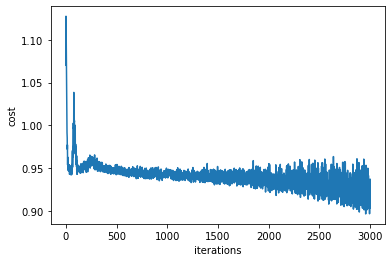

In [55]:
# plot the costs
plot_costs(costs)

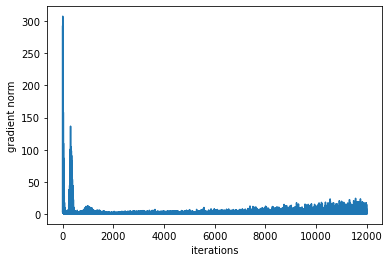

In [56]:
# plot the gradient norms
plot_grads(grad_norms)

## Measuring performance

Here we compute the accuracy of our model. We want high, and relatively the same values on training, validation, and test accuracy to know we have chosen a good architecture and dealt with regularization.

In [57]:
# compute training accuracy (write code to compute the accuracy of predictions on the training set)
predictions = []
for examples in X_pitches_train:
    predictions.append(predict(W,B,G,examples,output_type = 'genre'))
    
correct = 0
for i in range(len(y_pitches_train)):
    if predictions[i] == decoder(y_pitches_train[i]):
        correct += 1
train_accuracy = correct/X_pitches_train.shape[0]

correct_val = 0
for i in range(X_pitches_val.shape[0]):
    if all(predict(W,B,G,X_pitches_val[i]) == y_pitches_val[i]):
        correct_val += 1
val_accuracy = correct_val/X_pitches_val.shape[0]

correct_test = 0
for i in range(X_pitches_test.shape[0]):
    if all(predict(W,B,G,X_pitches_test[i]) == y_pitches_test[i]):
        correct_test += 1
test_accuracy = correct_test/X_pitches_test.shape[0]

print(f'Training Accuracy:     {train_accuracy}')
print(f'Validation Accuracy:   {val_accuracy}')
print(f'Test Accuracy:         {test_accuracy}')

Training Accuracy:     0.08333333333333333
Validation Accuracy:   0.05
Test Accuracy:         0.0
